In [1]:
!pip install wfdb -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.3 MB/s eta 0:00:0000:01


In [25]:
import zipfile
import os
import wfdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:
df = pd.read_csv("/kaggle/input/ptbxl-dataset/ptbxl_database.csv")

In [4]:
print(f"Total ECG records: {len(df)}")
print(f"Total unique patients: {df['patient_id'].nunique()}")
print(f"\n Dataset shape: {df.shape}")


Total ECG records: 21799
Total unique patients: 18869

 Dataset shape: (21799, 28)


In [5]:
df.columns.tolist()

['ecg_id',
 'patient_id',
 'age',
 'sex',
 'height',
 'weight',
 'nurse',
 'site',
 'device',
 'recording_date',
 'report',
 'scp_codes',
 'heart_axis',
 'infarction_stadium1',
 'infarction_stadium2',
 'validated_by',
 'second_opinion',
 'initial_autogenerated_report',
 'validated_by_human',
 'baseline_drift',
 'static_noise',
 'burst_noise',
 'electrodes_problems',
 'extra_beats',
 'pacemaker',
 'strat_fold',
 'filename_lr',
 'filename_hr']

In [6]:
first_record = df.iloc[0]
filename = first_record['filename_lr']  
ecg_path = os.path.join("/kaggle/input/ptbxl-dataset", filename)

print(f"Loading ECG from: {ecg_path}")

signal, fields = wfdb.rdsamp(ecg_path)

print(f"Signal shape: {signal.shape}") 
print(f"Duration: {signal.shape[0] / 100:.1f} seconds")
print(f"Number of leads: {signal.shape[1]}")  
print(f"Lead names: {fields['sig_name']}")

# Display signal statistics
print(f"\n Signal statistics:")
print(f"  - Min value: {signal.min():.3f} mV")
print(f"  - Max value: {signal.max():.3f} mV")
print(f"  - Mean: {signal.mean():.3f} mV")


Loading ECG from: /kaggle/input/ptbxl-dataset/records100/00000/00001_lr
Signal shape: (1000, 12)
Duration: 10.0 seconds
Number of leads: 12
Lead names: ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

 Signal statistics:
  - Min value: -1.377 mV
  - Max value: 0.706 mV
  - Mean: 0.000 mV


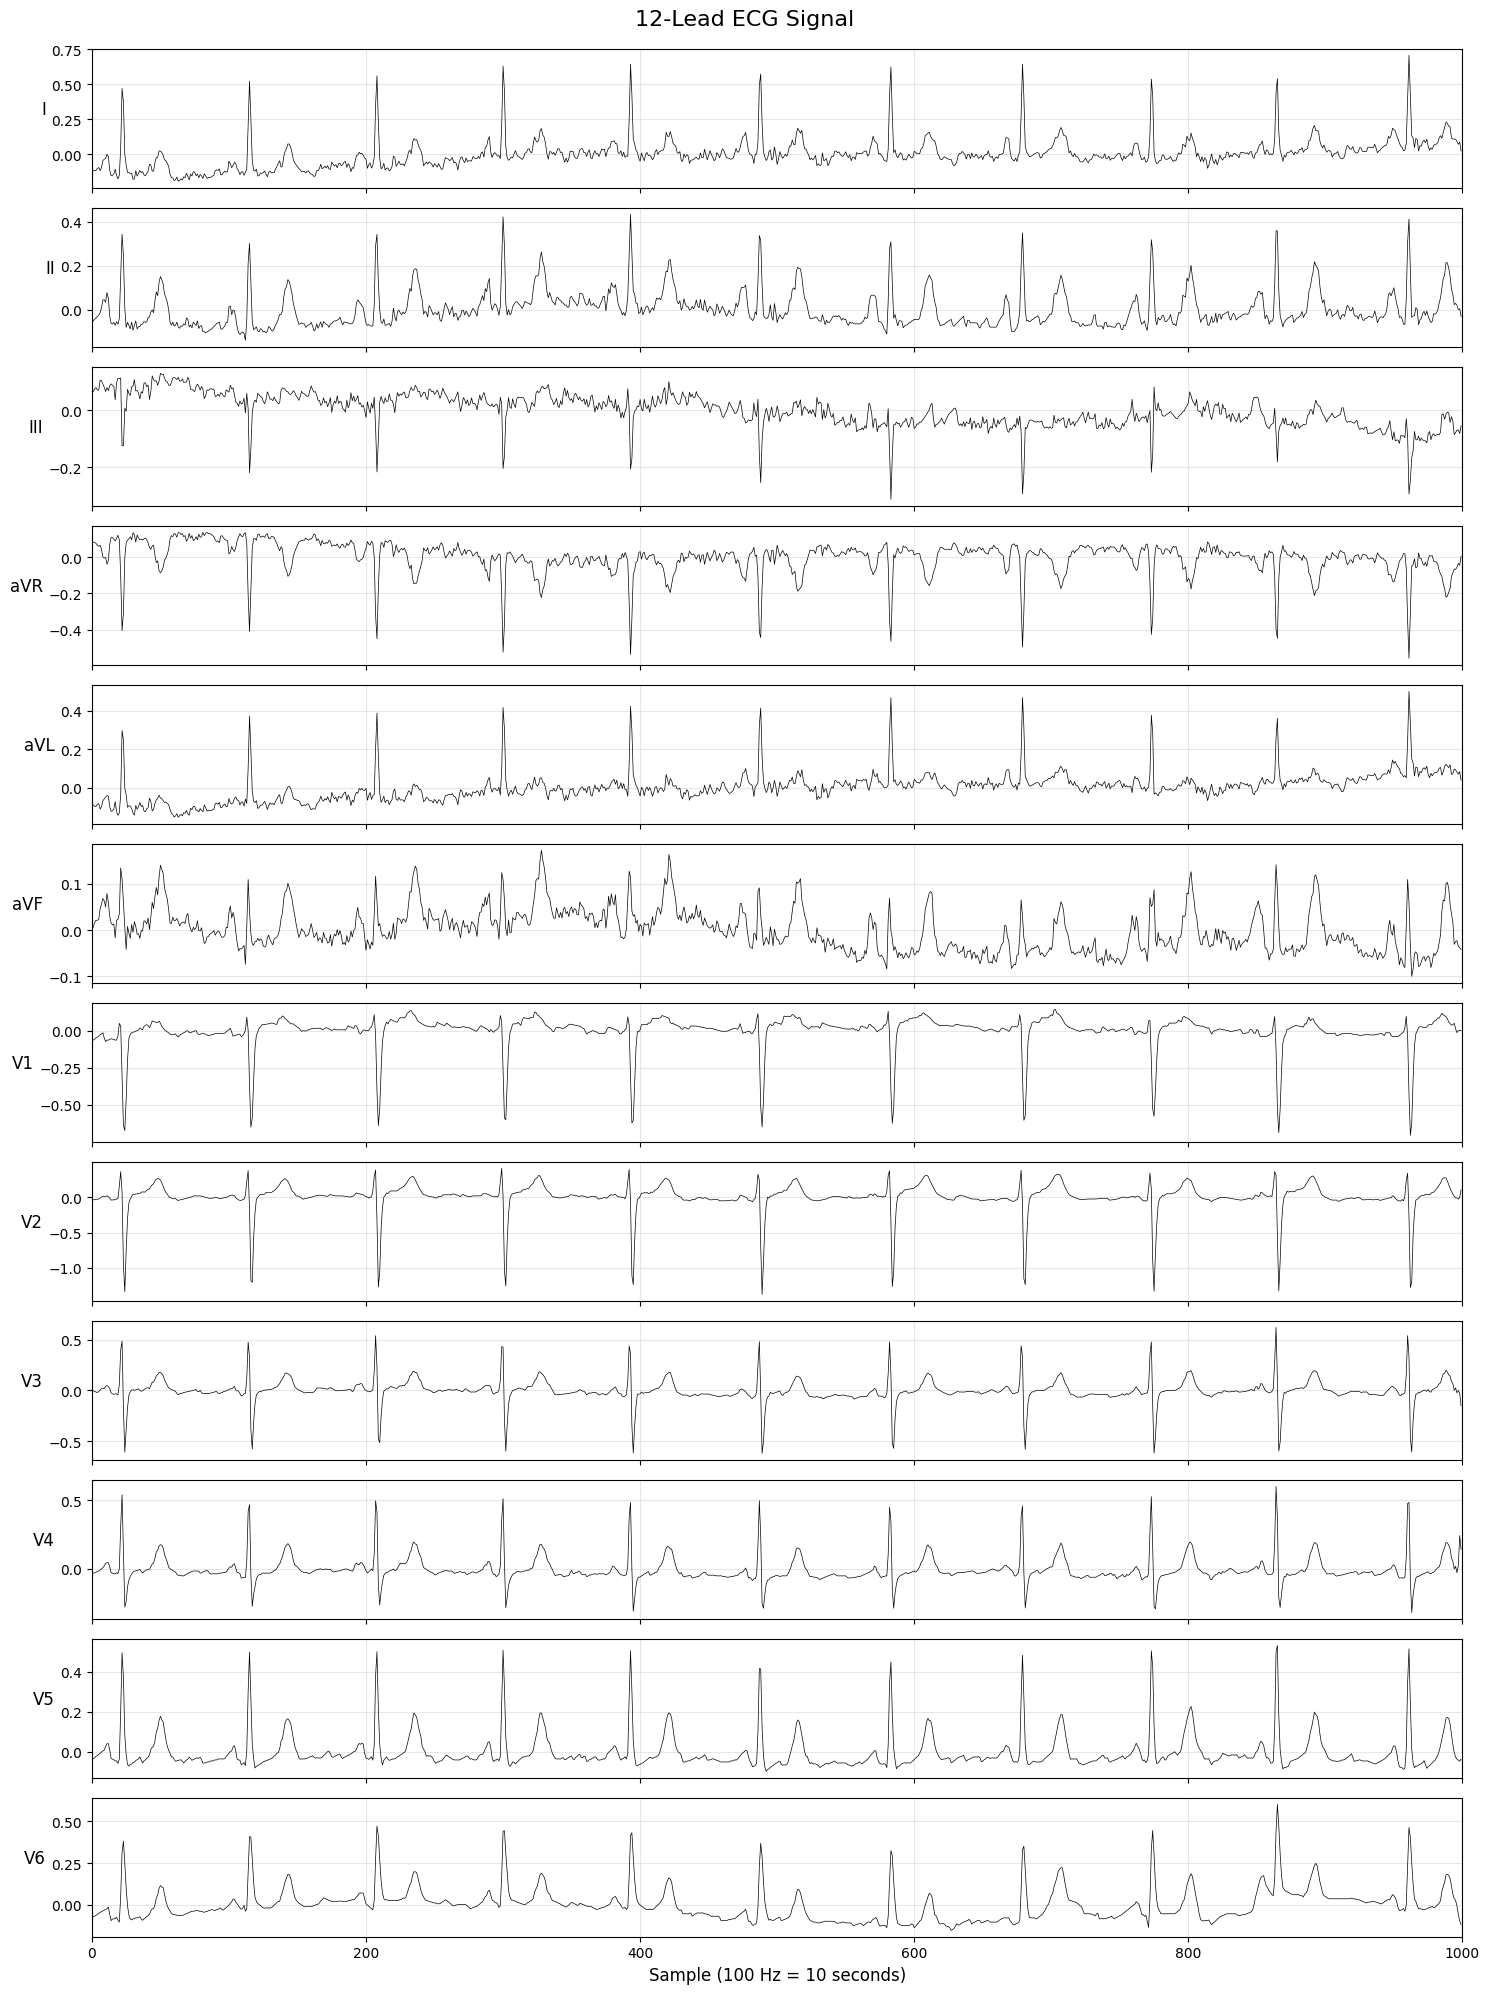

In [21]:
lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

fig, axes = plt.subplots(12, 1, figsize=(15, 20))
fig.suptitle('12-Lead ECG Signal', fontsize=16, y=0.995)

for i, (ax, lead_name) in enumerate(zip(axes, lead_names)):
    ax.plot(signal[:, i], linewidth=0.5, color='black')
    ax.set_ylabel(lead_name, fontsize=12, rotation=0, ha="right")
    ax.set_xlim(0, 1000)
    ax.grid(True, alpha=0.3)
    
    if i < 11:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Sample (100 Hz = 10 seconds)', fontsize=12)

plt.tight_layout()
plt.savefig('/kaggle/working/ecg_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
import ast

scp_df = pd.read_csv("/kaggle/input/ptbxl-dataset/scp_statements.csv", index_col=0)
print(f"\nTotal SCP codes: {len(scp_df)}")
print(f"\nFirst 5 rows:")
print(scp_df.head())

# Filter only diagnostic statements (diagnostic == 1)
diagnostic_df = scp_df[scp_df.diagnostic == 1]

print(f"\nDiagnostic statements: {len(diagnostic_df)}")
print("\nDiagnostic superclasses available:")
print(diagnostic_df['diagnostic_class'].value_counts())


Total SCP codes: 71

First 5 rows:
                          description  diagnostic  form  rhythm  \
NDT    non-diagnostic T abnormalities         1.0   1.0     NaN   
NST_          non-specific ST changes         1.0   1.0     NaN   
DIG                  digitalis-effect         1.0   1.0     NaN   
LNGQT                long QT-interval         1.0   1.0     NaN   
NORM                       normal ECG         1.0   NaN     NaN   

      diagnostic_class diagnostic_subclass  \
NDT               STTC                STTC   
NST_              STTC                NST_   
DIG               STTC                STTC   
LNGQT             STTC                STTC   
NORM              NORM                NORM   

                                      Statement Category  \
NDT                    other ST-T descriptive statements   
NST_   Basic roots for coding ST-T changes and abnorm...   
DIG                    other ST-T descriptive statements   
LNGQT                  other ST-T descriptiv

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [9]:
df['scp_codes'] = df['scp_codes'].apply(lambda x: ast.literal_eval(x))

print("SCP codes parsed")
print("\nExample scp_codes from first record:")
print(df.iloc[0]['scp_codes'])

# Function to aggregate diagnostic labels to superclasses
def aggregate_diagnostic(scp_codes_dict):
    superclasses = []
    for key in scp_codes_dict.keys():
        if key in diagnostic_df.index:
            superclass = diagnostic_df.loc[key]['diagnostic_class']
            superclasses.append(superclass)
    return list(set(superclasses))  # Remove duplicates

df['diagnostic_superclass'] = df['scp_codes'].apply(aggregate_diagnostic)

print("\nExample labels from first 5 records:")
print(df[['ecg_id', 'diagnostic_superclass']].head())


SCP codes parsed

Example scp_codes from first record:
{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}

Example labels from first 5 records:
   ecg_id diagnostic_superclass
0       1                [NORM]
1       2                [NORM]
2       3                [NORM]
3       4                [NORM]
4       5                [NORM]


In [10]:
from collections import Counter
all_labels = []
for labels in df['diagnostic_superclass']:
    all_labels.extend(labels)

label_counts = Counter(all_labels)

print("Label Distribution:")

for label, count in sorted(label_counts.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / len(df)) * 100
    print(f"{label:6s}: {count:5d} samples ({percentage:5.2f}%)")

print(f"\nTotal records: {len(df)}")

multi_label_count = sum(1 for labels in df['diagnostic_superclass'] if len(labels) > 1)
single_label_count = sum(1 for labels in df['diagnostic_superclass'] if len(labels) == 1)
no_label_count = sum(1 for labels in df['diagnostic_superclass'] if len(labels) == 0)

print(f"\nLabel Complexity:")
print(f"  - Single label: {single_label_count} records")
print(f"  - Multi-label: {multi_label_count} records")
print(f"  - No label: {no_label_count} records")


Label Distribution:
NORM  :  9514 samples (43.64%)
MI    :  5469 samples (25.09%)
STTC  :  5235 samples (24.01%)
CD    :  4898 samples (22.47%)
HYP   :  2649 samples (12.15%)

Total records: 21799

Label Complexity:
  - Single label: 16244 records
  - Multi-label: 5144 records
  - No label: 411 records


In [11]:
df_clean = df[df['diagnostic_superclass'].apply(len) > 0].copy()

print(f" Records with diagnostic labels: {len(df_clean)}")

train_df = df_clean[df_clean['strat_fold'] < 9].copy()   # Folds 1-8
val_df = df_clean[df_clean['strat_fold'] == 9].copy()    # Fold 9
test_df = df_clean[df_clean['strat_fold'] == 10].copy()  # Fold 10

print("\nData Split Complete!")
print(f"Training set:   {len(train_df):5d} samples ({len(train_df)/len(df_clean)*100:.1f}%)")
print(f"Validation set: {len(val_df):5d} samples ({len(val_df)/len(df_clean)*100:.1f}%)")
print(f"Test set:       {len(test_df):5d} samples ({len(test_df)/len(df_clean)*100:.1f}%)")

train_patients = set(train_df['patient_id'])
val_patients = set(val_df['patient_id'])
test_patients = set(test_df['patient_id'])

overlap_train_val = train_patients & val_patients
overlap_train_test = train_patients & test_patients
overlap_val_test = val_patients & test_patients

print(f"\nPatient Leakage Check:")
print(f"  - Train ∩ Val overlap: {len(overlap_train_val)} patients ")
print(f"  - Train ∩ Test overlap: {len(overlap_train_test)} patients ")
print(f"  - Val ∩ Test overlap: {len(overlap_val_test)} patients ")

if len(overlap_train_val) == 0 and len(overlap_train_test) == 0 and len(overlap_val_test) == 0:
    print("\nNo patient leakage detected - splits are valid")


 Records with diagnostic labels: 21388

Data Split Complete!
Training set:   17084 samples (79.9%)
Validation set:  2146 samples (10.0%)
Test set:        2158 samples (10.1%)

Patient Leakage Check:
  - Train ∩ Val overlap: 0 patients 
  - Train ∩ Test overlap: 0 patients 
  - Val ∩ Test overlap: 0 patients 

No patient leakage detected - splits are valid


In [12]:
unique_labels = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
label2idx = {label: idx for idx, label in enumerate(unique_labels)}
idx2label = {idx: label for label, idx in label2idx.items()}

print("Label Encoding:")
for label, idx in label2idx.items():
    print(f"{label:6s}:{idx}")
print(f"Number of classes: {len(unique_labels)}")

Label Encoding:
NORM  :0
MI    :1
STTC  :2
CD    :3
HYP   :4
Number of classes: 5


In [13]:
import scipy.signal

def bandpass_filter(signal, lowcut=0.5, highcut=40, fs=100, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = scipy.signal.butter(order, [low, high], btype='band', output='sos')
    filtered_signal = scipy.signal.sosfiltfilt(sos, signal, axis=0)
    
    return filtered_signal

test_record_path = os.path.join("/kaggle/input/ptbxl-dataset", train_df.iloc[0]['filename_lr'])
test_signal, _ = wfdb.rdsamp(test_record_path)

print(f"Original signal shape: {test_signal.shape}")
filtered_signal = bandpass_filter(test_signal, lowcut=0.5, highcut=40, fs=100)
print(f"Filtered signal shape: {filtered_signal.shape}")

Original signal shape: (1000, 12)
Filtered signal shape: (1000, 12)


In [14]:
def normalize_signal(signal, epsilon=1e-8):
    mean = np.mean(signal, axis=0, keepdims=True)
    std = np.std(signal, axis=0, keepdims=True) + epsilon

    normalized_signal = (signal - mean) / std
    
    return normalized_signal

normalized_signal = normalize_signal(filtered_signal)

print(f"Original - Mean: {filtered_signal.mean():.6f}, Std: {filtered_signal.std():.6f}")
print(f"Normalized - Mean: {normalized_signal.mean():.6f}, Std: {normalized_signal.std():.6f}")

Original - Mean: 0.001074, Std: 0.102881
Normalized - Mean: 0.000000, Std: 1.000000


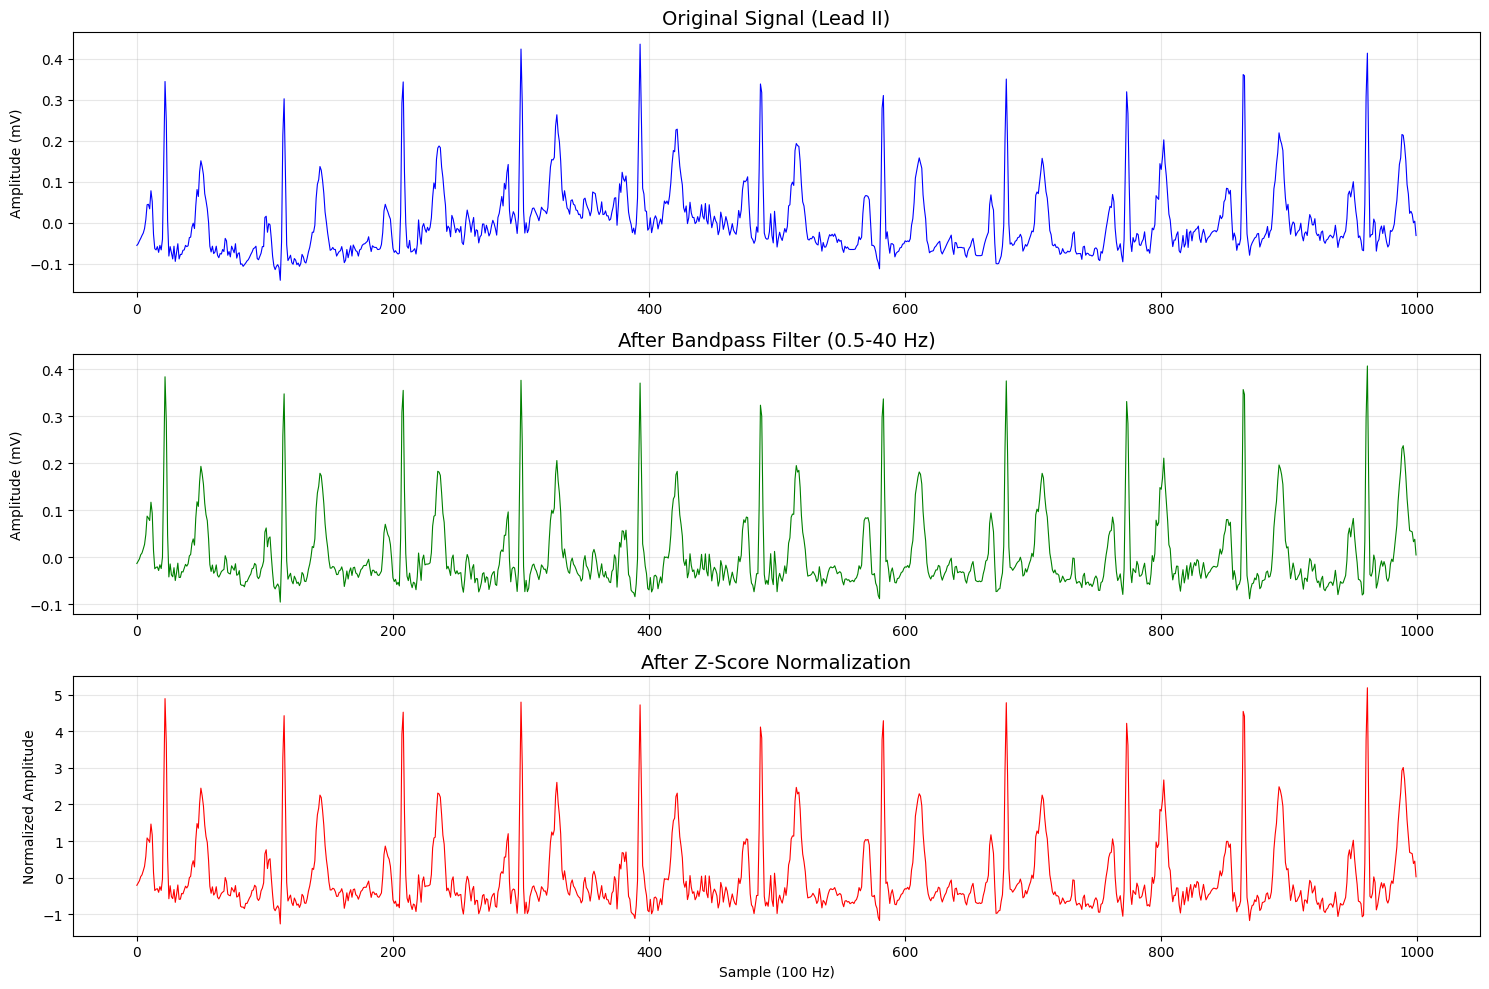

In [15]:
lead_idx = 1  #Lead II

fig, axes = plt.subplots(3, 1, figsize=(15, 10))
# Original
axes[0].plot(test_signal[:, lead_idx], color='blue', linewidth=0.8)
axes[0].set_title('Original Signal (Lead II)', fontsize=14)
axes[0].set_ylabel('Amplitude (mV)')
axes[0].grid(True, alpha=0.3)
# After bandpass filter
axes[1].plot(filtered_signal[:, lead_idx], color='green', linewidth=0.8)
axes[1].set_title('After Bandpass Filter (0.5-40 Hz)', fontsize=14)
axes[1].set_ylabel('Amplitude (mV)')
axes[1].grid(True, alpha=0.3)
# After normalization
axes[2].plot(normalized_signal[:, lead_idx], color='red', linewidth=0.8)
axes[2].set_title('After Z-Score Normalization', fontsize=14)
axes[2].set_ylabel('Normalized Amplitude')
axes[2].set_xlabel('Sample (100 Hz)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/various_signals.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
class ECGDataset(Dataset):
    def __init__(self, dataframe, data_path, label2idx,apply_filter=True, apply_normalization=True):
        self.df = dataframe.reset_index(drop=True)
        self.data_path = "/kaggle/input/ptbxl-dataset"
        self.label2idx = label2idx
        self.num_classes = len(label2idx)
        self.apply_filter = apply_filter
        self.apply_normalization = apply_normalization
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        record = self.df.iloc[idx]
        
        filename = record['filename_lr']
        signal_path = os.path.join(self.data_path, filename)
        signal, _ = wfdb.rdsamp(signal_path)  # Shape: (1000, 12)
        
        # Apply preprocessing
        if self.apply_filter:
            signal = bandpass_filter(signal, lowcut=0.5, highcut=40, fs=100)
        
        if self.apply_normalization:
            signal = normalize_signal(signal)
        
        signal = torch.FloatTensor(signal).transpose(0, 1)
        
        target = torch.zeros(self.num_classes, dtype=torch.float32)
        for label in record['diagnostic_superclass']:
            if label in self.label2idx:
                target[self.label2idx[label]] = 1.0
        
        return signal, target
    
    def get_label_distribution(self):
        label_counts = torch.zeros(self.num_classes)
        for i in range(len(self)):
            _, target = self[i]
            label_counts += target
        return label_counts

In [17]:
data_path="/kaggle/input/ptbxl-dataset"

train_dataset = ECGDataset(train_df, data_path, label2idx,apply_filter=True,apply_normalization=True)

val_dataset = ECGDataset(val_df,data_path,label2idx,apply_filter=True,apply_normalization=True)

test_dataset = ECGDataset(test_df,data_path,label2idx,apply_filter=True,apply_normalization=True)

print(f"Train dataset: {len(train_dataset)} samples")
print(f"Validation dataset: {len(val_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")

batch_size = 64
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2,pin_memory=True)

val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=2,pin_memory=True)

test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=2,pin_memory=True)

print(f"\nTrain loader: {len(train_loader)} batches")
print(f"Val loader: {len(val_loader)} batches")
print(f"Test loader: {len(test_loader)} batches")

Train dataset: 17084 samples
Validation dataset: 2146 samples
Test dataset: 2158 samples

Train loader: 267 batches
Val loader: 34 batches
Test loader: 34 batches


In [18]:
sample_batch_signals, sample_batch_labels = next(iter(train_loader))
print(f"  - Signals shape: {sample_batch_signals.shape}")  
print(f"  - Labels shape: {sample_batch_labels.shape}")    

print(f"\n  Signal stats:")
print(f"    - Min: {sample_batch_signals.min():.3f}")
print(f"    - Max: {sample_batch_signals.max():.3f}")
print(f"    - Mean: {sample_batch_signals.mean():.6f}")
print(f"    - Std: {sample_batch_signals.std():.3f}")

print(f"\n  First 3 samples' labels:")
for i in range(min(3, len(sample_batch_labels))):
    active_labels = [idx2label[j] for j, val in enumerate(sample_batch_labels[i]) if val == 1.0]
    print(f"    Sample {i}: {active_labels}")

print("\nLabel distribution in training set (calculated from metadata):")
from collections import Counter

train_label_counts = Counter()
for labels in train_df['diagnostic_superclass']:
    for label in labels:
        train_label_counts[label] += 1

for label in ['NORM', 'MI', 'STTC', 'CD', 'HYP']:
    count = train_label_counts[label]
    percentage = (count / len(train_df)) * 100
    print(f"  {label:6s}: {count:5d} samples ({percentage:5.2f}%)")



  - Signals shape: torch.Size([64, 12, 1000])
  - Labels shape: torch.Size([64, 5])

  Signal stats:
    - Min: -11.735
    - Max: 9.850
    - Mean: 0.000000
    - Std: 1.000

  First 3 samples' labels:
    Sample 0: ['STTC']
    Sample 1: ['STTC']
    Sample 2: ['MI', 'CD']

Label distribution in training set (calculated from metadata):
  NORM  :  7596 samples (44.46%)
  MI    :  4379 samples (25.63%)
  STTC  :  4186 samples (24.50%)
  CD    :  3907 samples (22.87%)
  HYP   :  2119 samples (12.40%)


In [22]:
class SingleLeadCNN(nn.Module):
    def __init__(self, num_classes=5, signal_length=1000):
        super(SingleLeadCNN, self).__init__()
        
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)
        
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(2)
        
        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(256)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = x[:, 1:2, :]  # Lead II: (batch, 1, 1000)
        
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = F.relu(self.bn4(self.conv4(x)))
        
        x = self.global_pool(x)  # (batch, 256, 1)
        x = x.squeeze(-1)        # (batch, 256)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  
        
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SingleLeadCNN(num_classes=5).to(device)

In [37]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: ~{total_params * 4 / 1024 / 1024:.2f} MB")


Model Statistics:
  Total parameters: 168,325
  Trainable parameters: 168,325
  Model size: ~0.64 MB


In [24]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',factor=0.5, patience=3)

In [26]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    for signals, targets in train_loader:
        signals, targets = signals.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(signals)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        preds = torch.sigmoid(outputs) > 0.5
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)
    
    f1_macro = f1_score(all_targets, all_preds, average='macro', zero_division=0)
    
    avg_loss = total_loss / len(train_loader)
    
    return avg_loss, f1_macro


def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for signals, targets in val_loader:
            signals, targets = signals.to(device), targets.to(device)
            
            outputs = model(signals)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            
            preds = torch.sigmoid(outputs) > 0.5
            all_preds.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)
    
    f1_macro = f1_score(all_targets, all_preds, average='macro', zero_division=0)
    
    f1_per_class = f1_score(all_targets, all_preds, average=None, zero_division=0)
    
    avg_loss = total_loss / len(val_loader)
    
    return avg_loss, f1_macro, f1_per_class

In [27]:
from tqdm import tqdm

num_epochs = 30
best_f1 = 0.0
patience_counter = 0
early_stop_patience = 7

history = {
    'train_loss': [],
    'train_f1': [],
    'val_loss': [],
    'val_f1': []
}

print("TRAINING SINGLE-LEAD CNN BASELINE")

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    
    train_loss, train_f1 = train_epoch(model, train_loader, criterion, optimizer, device)
    
    val_loss, val_f1, val_f1_per_class = validate(model, val_loader, criterion, device)
    
    scheduler.step(val_f1)
    
    history['train_loss'].append(train_loss)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)
    
    print(f"  Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val F1:   {val_f1:.4f}")
    print(f"  Per-class Val F1: {val_f1_per_class}")
    
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), 'best_single_lead_cnn.pth')
        print(f"  ✓ Best model saved! (F1: {best_f1:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= early_stop_patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print(f"TRAINING COMPLETE!")
print(f"Best Validation F1: {best_f1:.4f}")

TRAINING SINGLE-LEAD CNN BASELINE

Epoch [1/30]
  Train Loss: 0.4240 | Train F1: 0.4502
  Val Loss:   0.3857 | Val F1:   0.5026
  Per-class Val F1: [0.80273438 0.48463357 0.57359307 0.65197216 0.        ]
  ✓ Best model saved! (F1: 0.5026)

Epoch [2/30]
  Train Loss: 0.3910 | Train F1: 0.5120
  Val Loss:   0.3982 | Val F1:   0.4819
  Per-class Val F1: [0.81067961 0.53220697 0.55707763 0.50935252 0.        ]

Epoch [3/30]
  Train Loss: 0.3833 | Train F1: 0.5212
  Val Loss:   0.3848 | Val F1:   0.5459
  Per-class Val F1: [0.80851064 0.45762712 0.6460945  0.6587396  0.15873016]
  ✓ Best model saved! (F1: 0.5459)

Epoch [4/30]
  Train Loss: 0.3791 | Train F1: 0.5350
  Val Loss:   0.3838 | Val F1:   0.4844
  Per-class Val F1: [0.80539499 0.28527132 0.63479924 0.6185567  0.07773852]

Epoch [5/30]
  Train Loss: 0.3755 | Train F1: 0.5421
  Val Loss:   0.3722 | Val F1:   0.5198
  Per-class Val F1: [0.81344032 0.50352941 0.61280168 0.65432099 0.01476015]

Epoch [6/30]
  Train Loss: 0.3724 | Trai

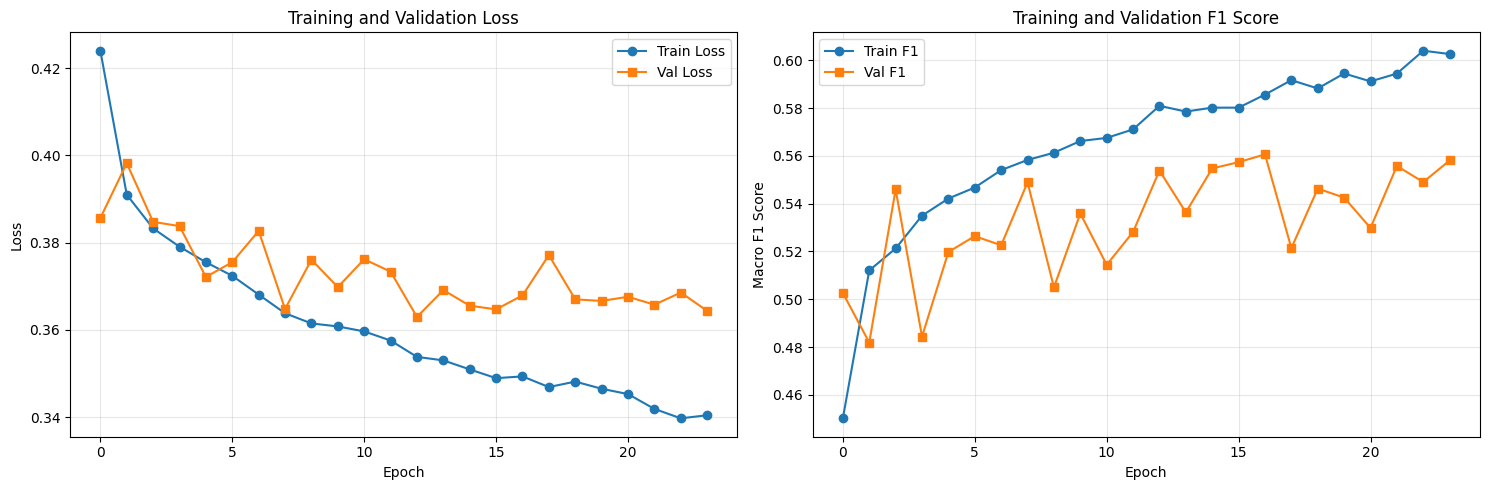

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# F1 plot
ax2.plot(history['train_f1'], label='Train F1', marker='o')
ax2.plot(history['val_f1'], label='Val F1', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Macro F1 Score')
ax2.set_title('Training and Validation F1 Score')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/training.png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:

model.load_state_dict(torch.load('best_single_lead_cnn.pth'))

test_loss, test_f1, test_f1_per_class = validate(model, test_loader, criterion, device)

print(" TEST SET RESULTS - SINGLE-LEAD CNN BASELINE")

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Macro F1: {test_f1:.4f}")
print("\nPer-class F1 scores:")
for label, f1 in zip(['NORM', 'MI', 'STTC', 'CD', 'HYP'], test_f1_per_class):
    print(f"  {label:6s}: {f1:.4f}")

 TEST SET RESULTS - SINGLE-LEAD CNN BASELINE
Test Loss: 0.3687
Test Macro F1: 0.5553

Per-class F1 scores:
  NORM  : 0.8114
  MI    : 0.4623
  STTC  : 0.6339
  CD    : 0.6840
  HYP   : 0.1847


In [31]:
class MultiLeadCNN(nn.Module):
    def __init__(self, num_classes=5, num_leads=12):
        super(MultiLeadCNN, self).__init__()
        
        self.conv1 = nn.Conv1d(num_leads, 64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)
        
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(2)
        
        self.conv4 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(512)
        
        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(512, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # x: (batch, 12, 1000) - all 12 leads processed together
        
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = F.relu(self.bn4(self.conv4(x)))
        
        x = self.global_pool(x)  # (batch, 512, 1)
        x = x.squeeze(-1)        # (batch, 512)
        
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x) 
        
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
multi_lead_model = MultiLeadCNN(num_classes=5, num_leads=12).to(device)

In [38]:
total_params = sum(p.numel() for p in multi_lead_model.parameters())
trainable_params = sum(p.numel() for p in multi_lead_model.parameters() if p.requires_grad)

print(f"\nModel Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: ~{total_params * 4 / 1024 / 1024:.2f} MB")

# Compare with single-lead model
single_lead_params = sum(p.numel() for p in model.parameters())
print(f"\nComparison:")
print(f"  Single-Lead CNN: {single_lead_params:,} parameters")
print(f"  Multi-Lead CNN:  {total_params:,} parameters")
print(f"  Ratio: {total_params/single_lead_params:.2f}x larger")


Model Statistics:
  Total parameters: 705,605
  Trainable parameters: 705,605
  Model size: ~2.69 MB

Comparison:
  Single-Lead CNN: 168,325 parameters
  Multi-Lead CNN:  705,605 parameters
  Ratio: 4.19x larger


In [33]:
multi_criterion = nn.BCEWithLogitsLoss()

multi_optimizer = torch.optim.Adam(multi_lead_model.parameters(), lr=0.001)

multi_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    multi_optimizer, 
    mode='max',
    factor=0.5, 
    patience=3
)


In [34]:
num_epochs = 30
best_multi_f1 = 0.0
patience_counter = 0
early_stop_patience = 7

multi_history = {
    'train_loss': [],
    'train_f1': [],
    'val_loss': [],
    'val_f1': []
}

print(" TRAINING MULTI-LEAD CNN BASELINE")
print("This model uses ALL 12 LEADS (vs Single-Lead uses only Lead II)")

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    
    train_loss, train_f1 = train_epoch(
        multi_lead_model, train_loader, multi_criterion, multi_optimizer, device
    )
    

    val_loss, val_f1, val_f1_per_class = validate(
        multi_lead_model, val_loader, multi_criterion, device
    )
    
    multi_scheduler.step(val_f1)
    
    multi_history['train_loss'].append(train_loss)
    multi_history['train_f1'].append(train_f1)
    multi_history['val_loss'].append(val_loss)
    multi_history['val_f1'].append(val_f1)
    

    print(f"  Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val F1:   {val_f1:.4f}")
    print(f"  Per-class Val F1: {val_f1_per_class}")
    
    if val_f1 > best_multi_f1:
        best_multi_f1 = val_f1
        torch.save(multi_lead_model.state_dict(), 'best_multi_lead_cnn.pth')
        print(f"  ✓ Best model saved! (F1: {best_multi_f1:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= early_stop_patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break


print(f"TRAINING COMPLETE!")
print(f"Best Validation F1: {best_multi_f1:.4f}")

 TRAINING MULTI-LEAD CNN BASELINE
This model uses ALL 12 LEADS (vs Single-Lead uses only Lead II)

Epoch [1/30]
  Train Loss: 0.3802 | Train F1: 0.5198
  Val Loss:   0.3656 | Val F1:   0.5492
  Per-class Val F1: [0.82942238 0.67732268 0.62441315 0.61498029 0.        ]
  ✓ Best model saved! (F1: 0.5492)

Epoch [2/30]
  Train Loss: 0.3274 | Train F1: 0.6119
  Val Loss:   0.3253 | Val F1:   0.6218
  Per-class Val F1: [0.8528989  0.67755991 0.71638862 0.6775     0.18471338]
  ✓ Best model saved! (F1: 0.6218)

Epoch [3/30]
  Train Loss: 0.3135 | Train F1: 0.6401
  Val Loss:   0.3339 | Val F1:   0.6385
  Per-class Val F1: [0.83686441 0.6913767  0.63917526 0.75211864 0.27299703]
  ✓ Best model saved! (F1: 0.6385)

Epoch [4/30]
  Train Loss: 0.3036 | Train F1: 0.6647
  Val Loss:   0.3045 | Val F1:   0.6577
  Per-class Val F1: [0.85219164 0.69121813 0.76022305 0.72345391 0.26139818]
  ✓ Best model saved! (F1: 0.6577)

Epoch [5/30]
  Train Loss: 0.2944 | Train F1: 0.6819
  Val Loss:   0.3321 | V

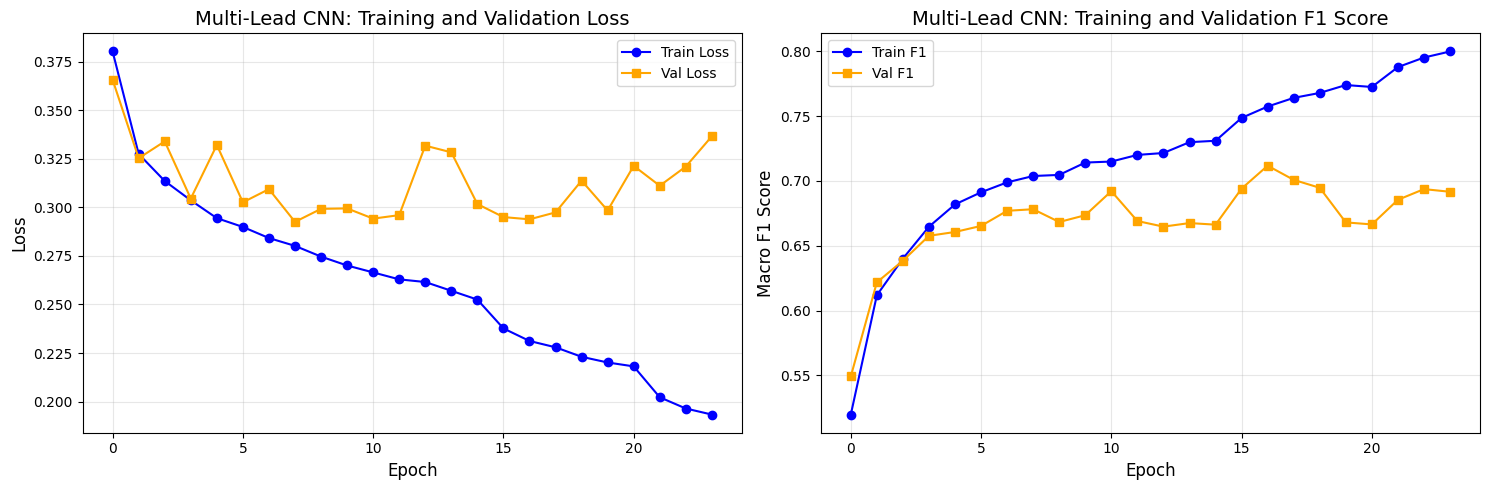

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(multi_history['train_loss'], label='Train Loss', marker='o', color='blue')
ax1.plot(multi_history['val_loss'], label='Val Loss', marker='s', color='orange')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Multi-Lead CNN: Training and Validation Loss', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# F1 plot
ax2.plot(multi_history['train_f1'], label='Train F1', marker='o', color='blue')
ax2.plot(multi_history['val_f1'], label='Val F1', marker='s', color='orange')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Macro F1 Score', fontsize=12)
ax2.set_title('Multi-Lead CNN: Training and Validation F1 Score', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/training_multilead.png', dpi=300, bbox_inches='tight')
plt.show()

In [42]:
multi_lead_model.load_state_dict(torch.load('best_multi_lead_cnn.pth'))

test_loss_multi, test_f1_multi, test_f1_per_class_multi = validate(
    multi_lead_model, test_loader, multi_criterion, device
)

print(" TEST SET RESULTS - MULTI-LEAD CNN BASELINE")

print(f"Test Loss: {test_loss_multi:.4f}")
print(f"Test Macro F1: {test_f1_multi:.4f}")
print("\nPer-class F1 scores:")
for label, f1 in zip(['NORM', 'MI', 'STTC', 'CD', 'HYP'], test_f1_per_class_multi):
    print(f"  {label:6s}: {f1:.4f}")

 TEST SET RESULTS - MULTI-LEAD CNN BASELINE
Test Loss: 0.2964
Test Macro F1: 0.7125

Per-class F1 scores:
  NORM  : 0.8602
  MI    : 0.7283
  STTC  : 0.7587
  CD    : 0.7508
  HYP   : 0.4646


In [43]:
comparison_data = {
    'Model': ['Single-Lead CNN', 'Multi-Lead CNN', 'Improvement'],
    'Leads Used': ['1 (Lead II)', '12 (All)', '-'],
    'Parameters': [f'{single_lead_params:,}', f'{total_params:,}', f'{total_params/single_lead_params:.2f}x'],
    'Val F1': [f'{best_f1:.4f}', f'{best_multi_f1:.4f}', f'+{(best_multi_f1-best_f1):.4f}'],
    'Test F1': [f'{test_f1:.4f}', f'{test_f1_multi:.4f}', f'+{(test_f1_multi-test_f1):.4f}']
}

comparison_df = pd.DataFrame(comparison_data)

print("BASELINE MODELS COMPARISON")
print(comparison_df.to_string(index=False))

pct_improvement = ((test_f1_multi - test_f1) / test_f1) * 100
print(f"\nMulti-Lead CNN improves over Single-Lead by {pct_improvement:.2f}%")

BASELINE MODELS COMPARISON
          Model  Leads Used Parameters  Val F1 Test F1
Single-Lead CNN 1 (Lead II)    168,325  0.5606  0.5553
 Multi-Lead CNN    12 (All)    705,605  0.7118  0.7125
    Improvement           -      4.19x +0.1512 +0.1573

Multi-Lead CNN improves over Single-Lead by 28.32%


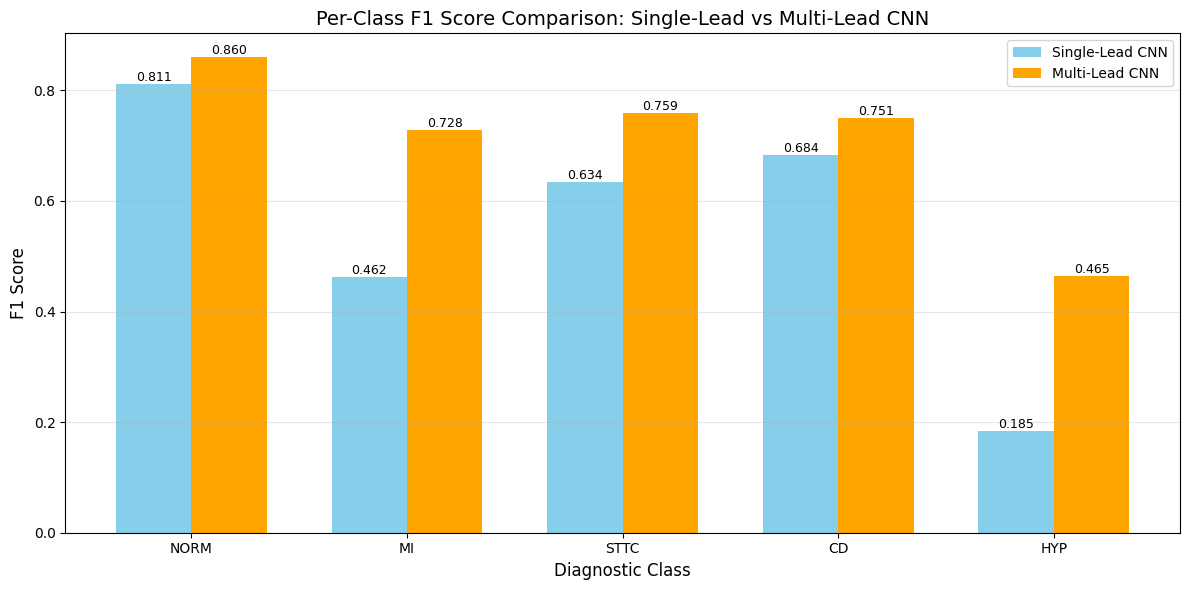

In [44]:
class_labels = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

model.load_state_dict(torch.load('best_single_lead_cnn.pth'))
_, _, test_f1_per_class_single = validate(model, test_loader, criterion, device)

x = np.arange(len(class_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, test_f1_per_class_single, width, label='Single-Lead CNN', color='skyblue')
bars2 = ax.bar(x + width/2, test_f1_per_class_multi, width, label='Multi-Lead CNN', color='orange')

ax.set_xlabel('Diagnostic Class', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('Per-Class F1 Score Comparison: Single-Lead vs Multi-Lead CNN', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(class_labels)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('/kaggle/working/per_class_comparision.png', dpi=300, bbox_inches='tight')
plt.show()

<h2>HNFAN Implementation</h2>

In [45]:
# Lead Level CNN Encoder that processes each lead individually
class LeadCNN(nn.Module):

    def __init__(self, signal_length=1000, feature_dim=128):
        super(LeadCNN, self).__init__()
        
        # Lightweight 1D CNN for single lead
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)
        
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        self.fc = nn.Linear(128, feature_dim)
        
    def forward(self, x):
        # x: (batch_size, 1, signal_length)
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.global_pool(x).squeeze(-1)  
        x = self.fc(x)  
        return x


In [46]:
class FuzzyReliabilityEstimator(nn.Module):
    def __init__(self, feature_dim=128):
        super(FuzzyReliabilityEstimator, self).__init__()

        self.snr_low = nn.Parameter(torch.tensor([0.0, 0.5, 1.5]))
        self.snr_high = nn.Parameter(torch.tensor([2.0, 3.5, 5.0]))
        
        self.drift_low = nn.Parameter(torch.tensor([0.0, 0.1, 0.3]))
        self.drift_high = nn.Parameter(torch.tensor([0.4, 0.6, 1.0]))
        
        self.confidence_net = nn.Sequential(
            nn.Linear(feature_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def triangular_membership(self, x, params):

        a, b, c = params[0], params[1], params[2]
        
        # Left slope: (x - a) / (b - a)
        left = (x - a) / (b - a + 1e-8)
        # Right slope: (c - x) / (c - b)
        right = (c - x) / (c - b + 1e-8)
        
        membership = torch.maximum(
            torch.minimum(left, right),
            torch.zeros_like(x)
        )
        return torch.clamp(membership, 0, 1)
    
    def compute_snr(self, signal):

        # Signal power (mean of squared values)
        signal_power = torch.mean(signal ** 2, dim=-1)
        
        # Noise estimation (std of last 100 samples)
        noise_std = torch.std(signal[:, :, -100:], dim=-1)
        
        # SNR = signal_power / (noise_std^2)
        snr = signal_power / (noise_std ** 2 + 1e-8)
        return torch.clamp(snr, 0, 10)  # Clamp to reasonable range
    
    def compute_baseline_drift(self, signal):
        # Remove mean baseline
        baseline = signal - torch.mean(signal, dim=-1, keepdim=True)
        # Drift is standard deviation of baseline
        drift = torch.std(baseline, dim=-1)
        return torch.clamp(drift, 0, 2)  # Clamp to reasonable range
    
    def forward(self, signals, features):

        batch_size, num_leads, _ = signals.shape
        
        # signal quality metrics
        snr = self.compute_snr(signals)  # (batch, num_leads)
        drift = self.compute_baseline_drift(signals)  # (batch, num_leads)
        
        # Normalize to [0, 5] range for fuzzy logic
        snr_normalized = snr / 2.0  # Typical SNR range
        drift_normalized = drift  # Already in good range
        
        # fuzzy membership functions
        # High SNR -> high reliability
        snr_membership_high = self.triangular_membership(
            snr_normalized, self.snr_high
        )
        
        # Low drift -> high reliability
        drift_membership_low = self.triangular_membership(
            drift_normalized, self.drift_low
        )
        
        # Fuzzy rule: IF SNR is HIGH AND Drift is LOW THEN Reliability is HIGH
        fuzzy_score = (snr_membership_high + drift_membership_low) / 2.0
        
        # CNN-based confidence (reshape for batch processing)
        features_flat = features.reshape(-1, features.shape[-1])
        cnn_confidence = self.confidence_net(features_flat)
        cnn_confidence = cnn_confidence.reshape(batch_size, num_leads)
        
        # Combine fuzzy logic and CNN confidence (weighted average)
        reliability = 0.6 * fuzzy_score + 0.4 * cnn_confidence
        
        return reliability

In [47]:
class FuzzyAttentionFusion(nn.Module):

    def __init__(self, feature_dim=128):
        super(FuzzyAttentionFusion, self).__init__()
        self.feature_dim = feature_dim
        
    def forward(self, features, reliability_scores):
        # Normalize reliability scores to get attention weights
        # alpha_i = R_i / sum(R_j)
        attention_weights = reliability_scores / (
            torch.sum(reliability_scores, dim=1, keepdim=True) + 1e-8
        )
        
        # Weighted sum: H = sum(alpha_i * h_i)
        fused_features = torch.sum(
            attention_weights.unsqueeze(-1) * features, 
            dim=1
        )
        
        return fused_features, attention_weights

In [52]:
class SimpleHNFAN(nn.Module):
    def __init__(self, num_leads=12, signal_length=1000, 
                 feature_dim=128, num_classes=5):
        super(SimpleHNFAN, self).__init__()
        
        self.num_leads = num_leads
        
        self.shared_encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            
            nn.AdaptiveAvgPool1d(1)
        )
        
        self.feature_projection = nn.Linear(128, feature_dim)
        
        self.reliability_net = nn.Sequential(
            nn.Linear(feature_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()  # Output reliability score [0, 1]
        )
        
        # Attention fusion (same as before)
        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x, return_attention=False):
        batch_size, num_leads, signal_length = x.shape
        
        # Extract features from each lead
        lead_features = []
        reliability_scores = []
        
        for i in range(num_leads):
            lead_signal = x[:, i:i+1, :]  # (batch, 1, signal_length)
            
            # Encode
            encoded = self.shared_encoder(lead_signal).squeeze(-1)  # (batch, 128)
            features = self.feature_projection(encoded)  # (batch, feature_dim)
            
            # Get reliability
            reliability = self.reliability_net(features).squeeze(-1)  # (batch,)
            
            lead_features.append(features)
            reliability_scores.append(reliability)
        
        # Stack
        lead_features = torch.stack(lead_features, dim=1)  # (batch, 12, feature_dim)
        reliability_scores = torch.stack(reliability_scores, dim=1)  # (batch, 12)
        
        # Attention fusion
        attention_weights = reliability_scores / (
            torch.sum(reliability_scores, dim=1, keepdim=True) + 1e-8
        )
        
        fused_features = torch.sum(
            attention_weights.unsqueeze(-1) * lead_features,
            dim=1
        )  # (batch, feature_dim)
        
        # Classify
        output = self.classifier(fused_features)
        
        if return_attention:
            return output, attention_weights
        return output

simple_hnfan = SimpleHNFAN(
    num_leads=12,
    signal_length=1000,
    feature_dim=128,
    num_classes=5
).to(device)

print("HNFAN created!")
print(f"Parameters: {sum(p.numel() for p in simple_hnfan.parameters()):,}")


HNFAN created!
Parameters: 94,854


In [53]:
print("\nTesting HNFAN forward pass...")

test_signals, test_labels = next(iter(train_loader))
test_signals = test_signals.to(device)

print(f"Input shape: {test_signals.shape}")

# Forward pass without attention
outputs = hnfan_model(test_signals)
print(f"Output shape: {outputs.shape}")
print(f"Standard forward pass successful!")

outputs, attention_weights = hnfan_model(test_signals, return_attention=True)
print(f"\nAttention weights shape: {attention_weights.shape}")
print(f"Sample attention weights (first ECG):")
lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
for lead_name, weight in zip(lead_names, attention_weights[0].cpu().detach().numpy()):
    print(f"  {lead_name:4s}: {weight:.4f}")

print(f"\nAttention mechanism working!")
print(f"Sum of attention weights: {attention_weights[0].sum():.4f}")



Testing HNFAN forward pass...
Input shape: torch.Size([64, 12, 1000])
Output shape: torch.Size([64, 5])
Standard forward pass successful!

Attention weights shape: torch.Size([64, 12])
Sample attention weights (first ECG):
  I   : 0.0929
  II  : 0.0637
  III : 0.1047
  aVR : 0.1365
  aVL : 0.1458
  aVF : 0.1217
  V1  : 0.0799
  V2  : 0.0368
  V3  : 0.0680
  V4  : 0.0524
  V5  : 0.0403
  V6  : 0.0572

Attention mechanism working!
Sum of attention weights: 1.0000


In [55]:

simple_criterion = nn.BCEWithLogitsLoss()

simple_optimizer = torch.optim.Adam(simple_hnfan.parameters(), lr=0.002) 

simple_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    simple_optimizer,
    mode='max',
    factor=0.5,
    patience=5
)

num_epochs = 30  
best_simple_f1 = 0.0
patience_counter = 0
early_stop_patience = 10  

simple_history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    
    # Train
    train_loss, train_f1 = train_epoch(
        simple_hnfan, train_loader, simple_criterion, simple_optimizer, device
    )
    
    # Validate
    val_loss, val_f1, val_f1_per_class = validate(
        simple_hnfan, val_loader, simple_criterion, device
    )
    
    # Update learning rate
    simple_scheduler.step(val_f1)
    
    # Store history
    simple_history['train_loss'].append(train_loss)
    simple_history['train_f1'].append(train_f1)
    simple_history['val_loss'].append(val_loss)
    simple_history['val_f1'].append(val_f1)
    
    # Print metrics
    print(f"  Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val F1:   {val_f1:.4f}")
    
    # Compare with Multi-Lead
    improvement = val_f1 - best_multi_f1
    print(f"  vs Multi-Lead baseline: {improvement:+.4f}", end="")
    if improvement > 0:
        print(" ")
    else:
        print(f" (need +{abs(improvement):.4f} to beat baseline)")
    
    # Save best model
    if val_f1 > best_simple_f1:
        best_simple_f1 = val_f1
        torch.save(simple_hnfan.state_dict(), 'best_simple_hnfan.pth')
        print(f"  ✓ Best model saved! (F1: {best_simple_f1:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= early_stop_patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break


print(f"TRAINING COMPLETE")
print("--------------------")
print(f"Best Validation F1: {best_simple_f1:.4f}")
print(f"Multi-Lead Baseline: {best_multi_f1:.4f}")
if best_simple_f1 > best_multi_f1:
    print(f"HNFAN BEATS BASELINE by {best_simple_f1 - best_multi_f1:+.4f}!")
else:
    print(f"Still {best_multi_f1 - best_simple_f1:.4f} behind baseline")


Epoch [1/30]
  Train Loss: 0.3906 | Train F1: 0.5027
  Val Loss:   0.4458 | Val F1:   0.4247
  vs Multi-Lead baseline: -0.2871 (need +0.2871 to beat baseline)
  ✓ Best model saved! (F1: 0.4247)

Epoch [2/30]
  Train Loss: 0.3484 | Train F1: 0.5917
  Val Loss:   0.4192 | Val F1:   0.4670
  vs Multi-Lead baseline: -0.2448 (need +0.2448 to beat baseline)
  ✓ Best model saved! (F1: 0.4670)

Epoch [3/30]
  Train Loss: 0.3326 | Train F1: 0.6218
  Val Loss:   0.4069 | Val F1:   0.4643
  vs Multi-Lead baseline: -0.2475 (need +0.2475 to beat baseline)

Epoch [4/30]
  Train Loss: 0.3213 | Train F1: 0.6407
  Val Loss:   0.4496 | Val F1:   0.4123
  vs Multi-Lead baseline: -0.2995 (need +0.2995 to beat baseline)

Epoch [5/30]
  Train Loss: 0.3142 | Train F1: 0.6507
  Val Loss:   0.4063 | Val F1:   0.4306
  vs Multi-Lead baseline: -0.2812 (need +0.2812 to beat baseline)

Epoch [6/30]
  Train Loss: 0.3076 | Train F1: 0.6581
  Val Loss:   0.3929 | Val F1:   0.4500
  vs Multi-Lead baseline: -0.2618 (n

KeyboardInterrupt: 